# Hyperparameter Tuning

In [1]:
import joblib

# Import models
lgbm_model = joblib.load("../models/lgbm_base_model.joblib")
catboost_model = joblib.load("../models/catboost_base_model.joblib")

In [2]:
import pandas as pd

train_df = pd.read_csv("../datasets/UNSW_NB15_preprocessed_training-set.csv")
test_df = pd.read_csv("../datasets/UNSW_NB15_preprocessed_testing-set.csv")

**Prepare Data**

In [3]:
# Split train set
X_train = train_df.drop(columns=["id", "attack_cat", "label"])
y_train = train_df["label"]

# Split test set
X_test = test_df.drop(columns=["id", "attack_cat", "label"])
y_test = test_df["label"]

## LightGBM

In [6]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

lgbm_param_dist = {
    "num_leaves": np.arange(20, 150, 10),
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [100, 500, 1000, 1500],
    "max_depth": np.arange(3, 15, 2),
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "device": ["gpu"]
}

lgbm_random_search = RandomizedSearchCV(
    lgbm_model,  
    param_distributions=lgbm_param_dist,
    n_iter=30,
    cv=5,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1,
    random_state=42
)

lgbm_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\emrev\PycharmProjects\vigiNIDS\.venv\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
13 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\emrev\PycharmProjects\vigiNIDS\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\emrev\PycharmProjects\vigiNIDS\.venv\lib\site-packages\lightgbm\sklearn.py", line 1284, in fit
    super().fit(
  File "C:\Users\emrev\PycharmProjects\vigiNIDS\.venv\lib\site-packages\lightgbm\sklearn.py", line 955, in fit
    self._Booster = train(


[LightGBM] [Info] Number of positive: 119341, number of negative: 56000
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6932
[LightGBM] [Info] Number of data points in the train set: 175341, number of used features: 58
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 39 dense feature groups (6.69 MB) transferred to GPU in 0.008132 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.680622 -> initscore=0.756633
[LightGBM] [Info] Start training from score 0.756633


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(device='gpu'), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'device': ['gpu'],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': array([ 3,  5,  7,  9, 11, 13]),
                                        'n_estimators': [100, 500, 1000, 1500],
                                        'num_leaves': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140]),
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=2)

In [7]:
print("Best Parameters:", lgbm_random_search.best_params_)
print("Best Score:", lgbm_random_search.best_score_)

Best Parameters: {'subsample': 0.8, 'num_leaves': 20, 'n_estimators': 1500, 'max_depth': 13, 'learning_rate': 0.05, 'device': 'gpu', 'colsample_bytree': 0.8}
Best Score: 0.9149199591765713


In [8]:
lgbm_random_search.score(X_test, y_test)

0.8727469270757421

In [9]:
# Import our custom function from ./src/utils/print_unique_values.py
import sys
import os
from pathlib import Path

# Get the current notebook's directory
notebook_dir = Path.cwd()

# Add the src directory to the sys.path
sys.path.append(str(notebook_dir.parent))  # Go up one level from notebooks

# Import the function
from utils.evaluate_classification import evaluate_classification
from utils.plot_auc_roc import plot_auc_roc
from utils.plot_confusion_matrix import plot_confusion_matrix

In [10]:
# Predict labels and probabilities
y_pred = lgbm_random_search.predict(X_test)
y_proba = lgbm_random_search.predict_proba(X_test)[:, 1]

In [11]:
# Get evaluation metrics
lgbm_metrics = evaluate_classification(y_test, y_pred, "LightGBM")
print("Evaluation Metrics:")
lgbm_metrics

Evaluation Metrics:


{'Model Name': 'LightGBM',
 'Accuracy': 0.8727469270757421,
 'Precision': 0.8210371189094593,
 'Recall': 0.9831906820788847,
 'F1 Score': 0.89482718813054}

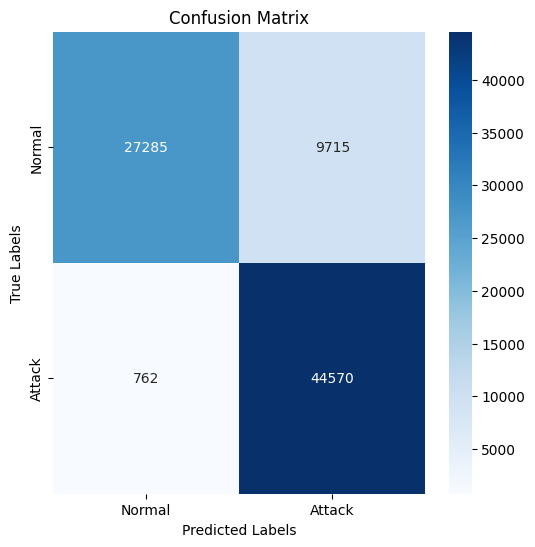

In [12]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names=["Normal", "Attack"])

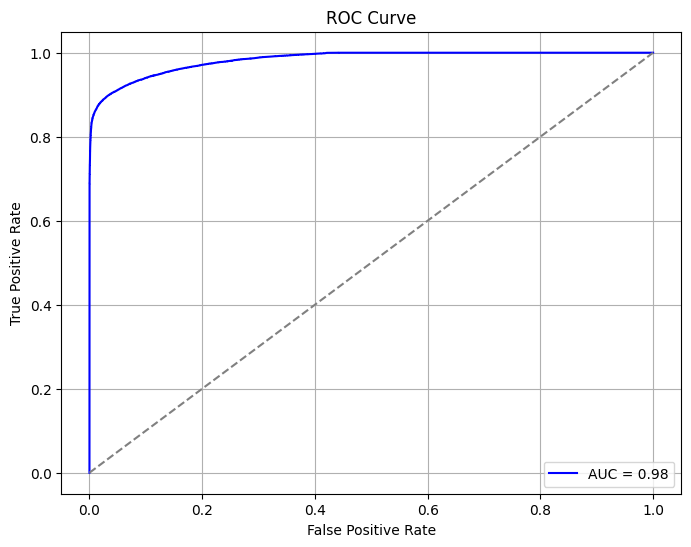

AUC: 0.9833


In [13]:
# Plot AUC-ROC
lgbm_auc = plot_auc_roc(y_test, y_proba)
print(f"AUC: {lgbm_auc:.4f}")

In [14]:
# Save the tuned LightGBM model
joblib.dump(lgbm_random_search, "../models/lgbm_rs_model.joblib")

['../models/lgbm_rs_model.joblib']

**GridSearchCV**

In [12]:
lgbm_param_grid = {
    "num_leaves": [10, 20, 30],  # Narrow around 20
    "learning_rate": [0.05, 0.1, 0.15],  # Narrow around 0.1
    "n_estimators": [1300, 1500, 1700],  # Narrow around 1500
    "max_depth": [2, 3, 4],  # Narrow around 3
    "subsample": [0.7, 0.8, 0.9],  # Narrow around 0.8
    "colsample_bytree": [0.7, 0.8, 0.9]  # Narrow around 0.8
}

# Initialize GridSearchCV
lgbm_grid_search = GridSearchCV(
    estimator=lgbm_model,  # Your LightGBM model
    param_grid=lgbm_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV
lgbm_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


C:\Users\emrev\PycharmProjects\vigiNIDS\.venv\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\emrev\PycharmProjects\vigiNIDS\.venv\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
310 fits failed out of a total of 3645.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
210 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\emrev\PycharmProjects\vigiNIDS\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_

[LightGBM] [Info] Number of positive: 119341, number of negative: 56000
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6932
[LightGBM] [Info] Number of data points in the train set: 175341, number of used features: 58
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 39 dense feature groups (6.69 MB) transferred to GPU in 0.017615 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.680622 -> initscore=0.756633
[LightGBM] [Info] Start training from score 0.756633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

GridSearchCV(cv=5, estimator=LGBMClassifier(device='gpu'), n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [1300, 1500, 1700],
                         'num_leaves': [10, 20, 30],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='accuracy', verbose=2)

In [13]:
# Print the best parameters and best score
print("Best GridSearchCV Parameters:", lgbm_grid_search.best_params_)
print("Best GridSearchCV Score:", lgbm_grid_search.best_score_)

Best GridSearchCV Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 1300, 'num_leaves': 10, 'subsample': 0.8}
Best GridSearchCV Score: 0.9162202914261259


In [14]:
lgbm_grid_search.score(X_test, y_test)

0.8676456298887432

In [15]:
# Predict labels and probabilities
y_pred = lgbm_random_search.predict(X_test)
y_proba = lgbm_random_search.predict_proba(X_test)[:, 1]

In [16]:
# Get evaluation metrics
lgbm_metrics = evaluate_classification(y_test, y_pred, "LightGBM")
print("Evaluation Metrics:")
lgbm_metrics

Evaluation Metrics:


{'Model Name': 'LightGBM',
 'Accuracy': 0.8735607054365253,
 'Precision': 0.8231005514229673,
 'Recall': 0.9812494485131915,
 'F1 Score': 0.8952442288727434}

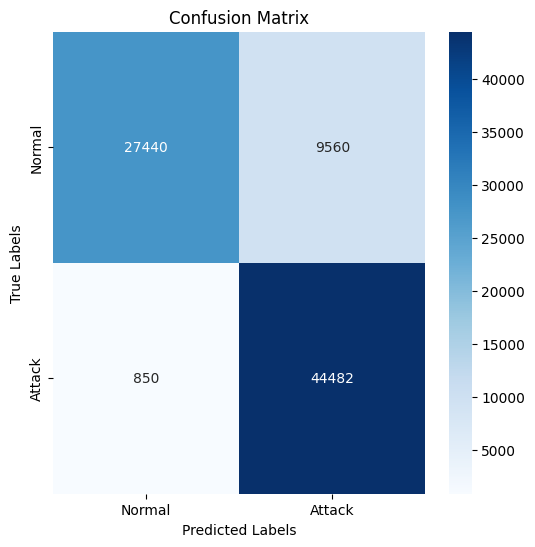

In [17]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names=["Normal", "Attack"])

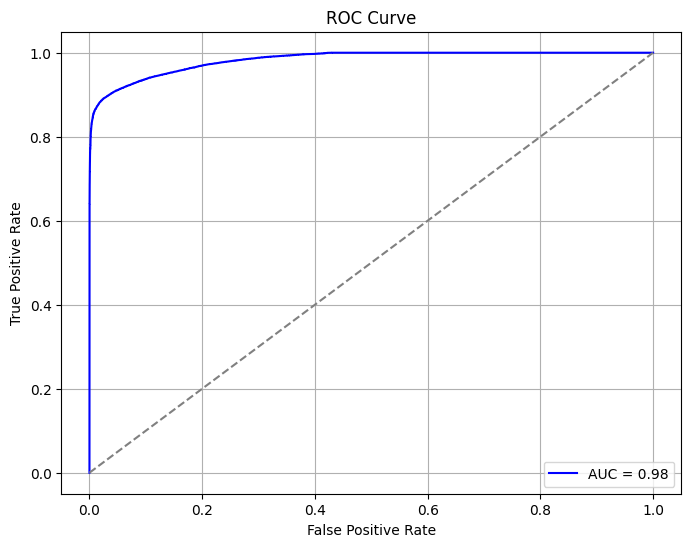

AUC: 0.9828


In [18]:
# Plot AUC-ROC
lgbm_auc = plot_auc_roc(y_test, y_proba)
print(f"AUC: {lgbm_auc:.4f}")

In [19]:
# Save the tuned LightGBM model
joblib.dump(lgbm_grid_search, "../models/lgbm_gs_model.joblib")

['../models/lgbm_gs_model.joblib']